In [135]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend
from sklearn.metrics import confusion_matrix, classification_report

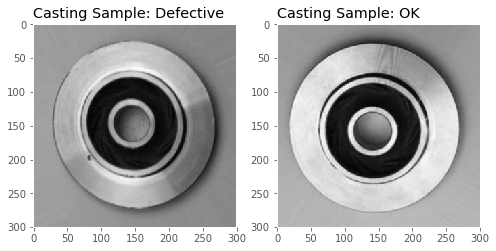

In [136]:
import os

# Specify directory of training data
dir_train = r"C:\Users\prane\OneDrive\Desktop\pjt\archive\casting_data\casting_data\train"
dir_train_def = os.path.join(dir_train, 'def_front\\')  # Class label: Defective
dir_train_ok = os.path.join(dir_train, 'ok_front\\')    # Class label: OK

# Specify directory of test data
dir_test = r"C:\Users\prane\OneDrive\Desktop\pjt\archive\casting_data\casting_data\test"
dir_test_def = os.path.join(dir_test, 'def_front\\')
dir_test_ok = os.path.join(dir_test, 'ok_front\\')

dir_val = r"C:\Users\prane\OneDrive\Desktop\pjt\archive\casting_data\casting_data\validation"
dir_val_def = os.path.join(dir_val, 'def_front\\')
dir_val_ok = os.path.join(dir_val, 'ok_front\\')

# Plot samples of defective and non-defective casting
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
sample_def = plt.imread(dir_train_def + os.listdir(dir_train_def)[0])
sample_ok = plt.imread(dir_train_ok + os.listdir(dir_train_ok)[0])
axes[0].imshow(sample_def)
axes[1].imshow(sample_ok)
axes[0].set_title('Casting Sample: Defective', loc='left')
axes[1].set_title('Casting Sample: OK', loc='left')
axes[0].grid(False)
axes[1].grid(False)
plt.show()

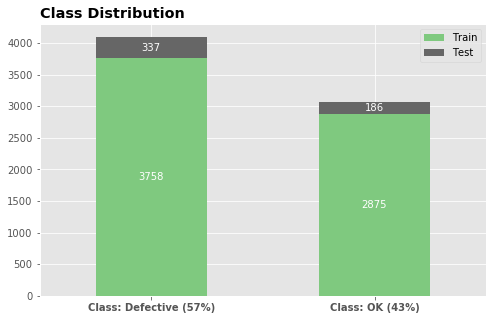

In [137]:
n_train = [len(os.listdir(dir_train_def)), len(os.listdir(dir_train_ok))]
n_test = [len(os.listdir(dir_test_def)), len(os.listdir(dir_test_ok))]
dist_df = pd.DataFrame(
    data=[n_train, n_test],
    columns=['Defective', 'OK'],
    index=['Train', 'Test'])

# Visualize class distribution
ax = dist_df.T.plot(kind='bar', stacked=True, rot=0, figsize=(8,5), colormap='Accent')
ax.set_title('Class Distribution', loc='left', weight='bold')
for bar in ax.patches:
    ax.text(bar.get_x()+bar.get_width()-0.25, 
            bar.get_y()+bar.get_height()/2,
            int(bar.get_height()),
            ha='center', va='center', color='white')
pct_def = 100*dist_df['Defective'].values.sum()/dist_df.values.sum()
pct_ok = 100-pct_def
ax.set_xticklabels([f'Class: Defective ({pct_def:.0f}%)',
                    f'Class: OK ({pct_ok:.0f}%)'], weight='bold')
plt.show()

In [140]:
image_gen = ImageDataGenerator(rescale=1/255, 
                               zoom_range=0.1, 
                               brightness_range=[0.9,1.0])

In [141]:
image_shape = (300,300,1) # 300 × 300、graysclaed (full-color : 3)
batch_size = 32

train_set = image_gen.flow_from_directory(dir_train,
                                            target_size=image_shape[:2],
                                            color_mode="grayscale",
                                            classes={'def_front': 0, 'ok_front': 1},
                                            batch_size=batch_size,
                                            class_mode='binary',
                                            shuffle=True,
                                            seed=0)

test_set = image_gen.flow_from_directory(dir_test,
                                           target_size=image_shape[:2],
                                           color_mode="grayscale",
                                           classes={'def_front': 0, 'ok_front': 1},
                                           batch_size=batch_size,
                                           class_mode='binary',
                                           shuffle=False,
                                           seed=0)

Found 6633 images belonging to 2 classes.
Found 523 images belonging to 2 classes.


In [142]:
train_set.class_indices

{'def_front': 0, 'ok_front': 1}

In [143]:
backend.clear_session()
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(7,7), strides=2, input_shape=image_shape, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, input_shape=image_shape, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, input_shape=image_shape, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Flatten())
model.add(Dense(units=224, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      800       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0         
__________

In [145]:
n_epochs = 20
results = model.fit_generator(train_set, epochs=n_epochs, validation_data=test_set, callbacks=[early_stop,checkpoint])

Epoch 1/20
207/208 [============================>.] - ETA: 0s - loss: 0.6152 - acc: 0.6661
Epoch 00001: val_loss improved from inf to 0.37578, saving model to casting_product_detection.hdf5
208/208 [==============================] - 199s 958ms/step - loss: 0.6143 - acc: 0.6668 - val_loss: 0.3758 - val_acc: 0.8681
Epoch 2/20
207/208 [============================>.] - ETA: 0s - loss: 0.3292 - acc: 0.8557
Epoch 00002: val_loss improved from 0.37578 to 0.17115, saving model to casting_product_detection.hdf5
208/208 [==============================] - 148s 710ms/step - loss: 0.3283 - acc: 0.8564 - val_loss: 0.1711 - val_acc: 0.9388
Epoch 3/20
207/208 [============================>.] - ETA: 0s - loss: 0.2013 - acc: 0.9199
Epoch 00003: val_loss improved from 0.17115 to 0.10085, saving model to casting_product_detection.hdf5
208/208 [==============================] - 152s 733ms/step - loss: 0.2008 - acc: 0.9201 - val_loss: 0.1009 - val_acc: 0.9598
Epoch 4/20
207/208 [===========================

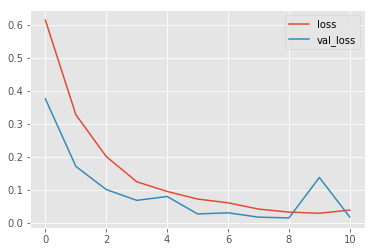

In [174]:
# Analyzing model performance
losses = pd.DataFrame(model.history.history)
losses[['loss', 'val_loss']].plot()

In [178]:
model_history = results.history
losses = pd.DataFrame(model_history)
#losses.index = map(lambda x : x+1, losses.index)
losses.head(3)

,val_loss,val_acc,loss,acc
0,0.375778,0.868069,0.614158,0.667571
1,0.171146,0.938815,0.327848,0.856324
2,0.100851,0.959847,0.200904,0.920247


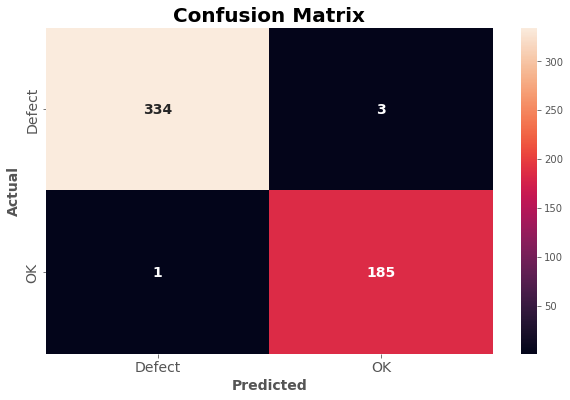

In [148]:
pred_probability = model.predict_generator(test_set)
predictions = pred_probability > 0.5

plt.figure(figsize=(10,6))
plt.title('Confusion Matrix', size=20, weight='bold')
sns.heatmap(
     confusion_matrix(test_set.classes, predictions),
     annot=True,
     annot_kws={'size':14, 'weight': 'bold'},
     fmt='d',
     xticklabels=['Defect', 'OK'],
     yticklabels=['Defect', 'OK'])
plt.tick_params(axis='both', labelsize=14)
plt.ylabel('Actual', size=14, weight='bold')
plt.xlabel('Predicted', size=14, weight='bold')
plt.show()

In [149]:
# defective is 0, ok is 1
print(classification_report(test_set.classes, predictions))

             precision    recall  f1-score   support

          0       1.00      0.99      0.99       337
          1       0.98      0.99      0.99       186

avg / total       0.99      0.99      0.99       523



C:\Users\prane\anaconda3\envs\python-cvcourse\lib\site-packages\pandas\core\indexes\range.py:720: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return super().__getitem__(key)
C:\Users\prane\anaconda3\envs\python-cvcourse\lib\site-packages\matplotlib\cbook\__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\prane\anaconda3\envs\python-cvcourse\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


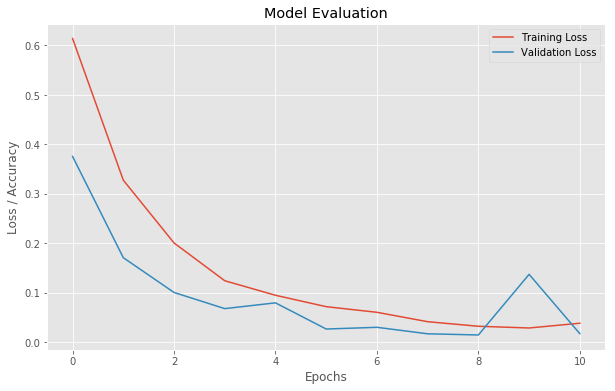

In [150]:
import matplotlib.pyplot as plt

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Training and validation loss
ax.plot(losses.index, losses['loss'], label='Training Loss')
ax.plot(losses.index, losses['val_loss'], label='Validation Loss')

# Training and validation accuracy
if 'accuracy' in losses.columns and 'val_accuracy' in losses.columns:
    ax.plot(losses.index, losses['accuracy'], label='Training Accuracy')
    ax.plot(losses.index, losses['val_accuracy'], label='Validation Accuracy')

# Setting labels and title
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss / Accuracy')
ax.set_title('Model Evaluation')
ax.legend()

# Showing grid
ax.grid(True)

# Displaying the plot
plt.show()

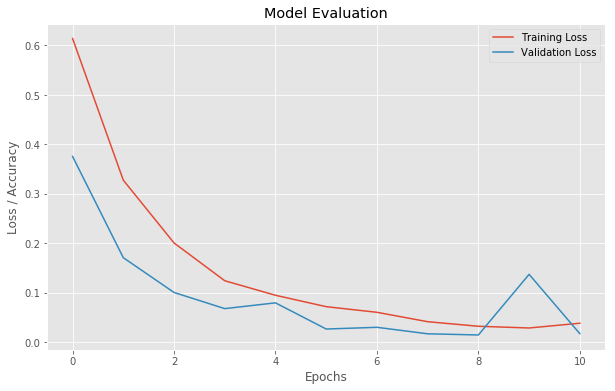

In [151]:
import matplotlib.pyplot as plt

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Training and validation loss
ax.plot(losses.index, losses['loss'], label='Training Loss')
ax.plot(losses.index, losses['val_loss'], label='Validation Loss')

# Training and validation accuracy
if 'accuracy' in losses.columns and 'val_accuracy' in losses.columns:
    ax.plot(losses.index, losses['accuracy'], label='Training Accuracy')
    ax.plot(losses.index, losses['val_accuracy'], label='Validation Accuracy')

# Setting labels and title
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss / Accuracy')
ax.set_title('Model Evaluation')
ax.legend()

# Showing grid
ax.grid(True)

# Displaying the plot
plt.show()


In [152]:
losses = pd.DataFrame(model_history)
losses.index = map(lambda x : x+1, losses.index)
losses.head(3)

,val_loss,val_acc,loss,acc
1,0.375778,0.868069,0.614158,0.667571
2,0.171146,0.938815,0.327848,0.856324
3,0.100851,0.959847,0.200904,0.920247


In [188]:
print(classification_report(test_set.classes, predictions, digits=3))

             precision    recall  f1-score   support

          0      0.997     0.991     0.994       337
          1      0.984     0.995     0.989       186

avg / total      0.992     0.992     0.992       523

